# NLP Medical Record Capstone Project

Here we will use natural language processing in order to identify medical condition listed in patient history notes.

![patient_history](exam.jpeg)


## Authors

- [@christian_freeman](https://github.com/cfreeman22)
- [@jared_godar](https://github.com/Jared-Godar)
- [@scott_schmidl](https://github.com/scottschmidl)
- [@brent_schriver](https://github.com/brentschriver)


## About the Project

Writing patient notes to document the history of a patient's complaint, exam findings, possible diagnoses, and care. Learning and assessing these skills requires feedback from other doctors.

Until recently, a part of clinical skills exams for medical students involved interacting with standardized patients and taking notes. These notes were later scored by trained physician raters in a labor intensive process.

This project seeks to use natural language processing to identify specific clinical concepts in patient nots.

---

## Project Goals

- Develop automated method to map clinical concepts from an exam ruberic to various ways in which these concepts are expressed in clinical patient notes written by medical students.

---

## Initial Questions

1. What clinical conditions are present for the 10 standardized patients?
2. On average, how many conditions do students correctly label?
3. What words or phrases are tied to specific patients and conditions?
4. How do we predict multiple outcomes in a multiclass classification process?
5. What other NLP libraries could be useful besides NLTK? (Spacey)
6. What other pre-trained medical NLP models would be good? (i.e., BioBERT)
7. What deep learning approaches would be appropriate to solving these questions?

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import re, os
import unicodedata
import json

import nltk
import nltk.sentiment
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from time import strftime

from wordcloud import WordCloud

from pprint import pprint

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

import acquire

import spacy
pd.set_option('display.max_colwidth', None)

import prepare_jag

import warnings
warnings.filterwarnings('ignore')


### Acquire and Prepare Data

- Load patient notes, labeled training data, and features dictionary from kaggle site
- Merge dataframes
- Added a basic clean column lowercaseing and removing special characters
  - Except for `-`: Important for note content (i.e, big difference between 3-4 beers and 34 beers)
- Added stemmed column with tokenized words and stopwords removed
  - Excluded `no` from stopwords. (hypertention vs. no hypertension is an important disctinion)
- Added lemmatized column with lemmatized words and stopwords removed
- Change datatypes of case numbers and other labels to `category`

In [19]:
df = prepare_jag.prep_train()

Test, notes, and features loaded.
Merged dataframes
Renamed 'pn_history' column to 'original'
Added a basic clean column lowercaseing and removing special characters
Added stemmed column with tokenized words and stopwords removed
Added lemmatized column with lemmatized words and stopwords removed
Data preparation complete


In [20]:
df.head(1)

id  case_num  pn_num  feature_num  \
0  00016_000         0      16            0   

                                                      feature_text  \
0  Family-history-of-MI-OR-Family-history-of-myocardial-infarction   

                         annotation     location  \
0  ['dad with recent heart attcak']  ['696 724']   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 original  \
0  HPI: 17yo M presents with palpitations. Patient reports 3-4 months of intermittent episodes of "heart beating/pounding out of my chest." 2 days ago during a soccer game had an episode, but this time had chest pressure and felt as if he were going to pass out (did not lose conciousness). Of note patient endorses abusing adderall, primarily to study (1-3 times per week). Before recent soccer game, took adderrall night before and morning of game. Denies shortness of breath, diaphoresis, fevers, chills, headache, fatigue, changes in sleep, changes in vision/hearing, abdominal paun, changes in bowel or urinary habits. \r\nPMHx: none\r\nRx: uses friends adderrall\r\nFHx: mom with "thyroid disease," dad with recent heart attcak\r\nAll: none\r\nImmunizations: up to date\r\nSHx: Freshmen in college. Endorses 3-4 drinks 3 nights / week (on weekends), denies tabacco, endorses trying marijuana. Sexually active with girlfriend x 1 year, uses condoms   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        clean  \
0  hpi 17yo presents palpitations patient reports 3-4 months intermittent episodes heart beating pounding chest 2 days ago soccer game episode time chest pressure felt going pass lose conciousness note patient endorses abusing adderall primarily study 1-3 times per week recent soccer game took adderrall night morning game denies shortness breath diaphoresis fevers chills headache fatigue changes sleep changes vision hearing abdominal paun changes bowel urinary habits pmhx none rx uses friends adderrall fhx mom thyroid disease dad recent heart attcak none immunizations date shx freshmen college endorses 3-4 drinks 3 nights week weekends denies tabacco endorses trying marijuana sexually active girlfriend x 1 year uses condoms   

                                                                                                                                                                                                                                                                                       

In [21]:
df.shape

(14300, 11)

How many times are each of the ten cases represented in notes?

In [22]:
# Value counts of notes per case
df.case_num.value_counts().sort_index()

0    1300
1    1300
2    1700
3    1600
4    1000
5    1800
6    1200
7     900
8    1800
9    1700
Name: case_num, dtype: int64

In [23]:
# Look at distribution of cases
cases = pd.concat([df.case_num.value_counts().sort_index(), df.case_num.value_counts(normalize = True)], axis = 1)
cases.columns = ['n', 'percent']
cases

n   percent
0  1300  0.090909
1  1300  0.090909
2  1700  0.118881
3  1600  0.111888
4  1000  0.069930
5  1800  0.125874
6  1200  0.083916
7   900  0.062937
8  1800  0.125874
9  1700  0.118881

<AxesSubplot:title={'center':'Case Representation'}, ylabel='n'>

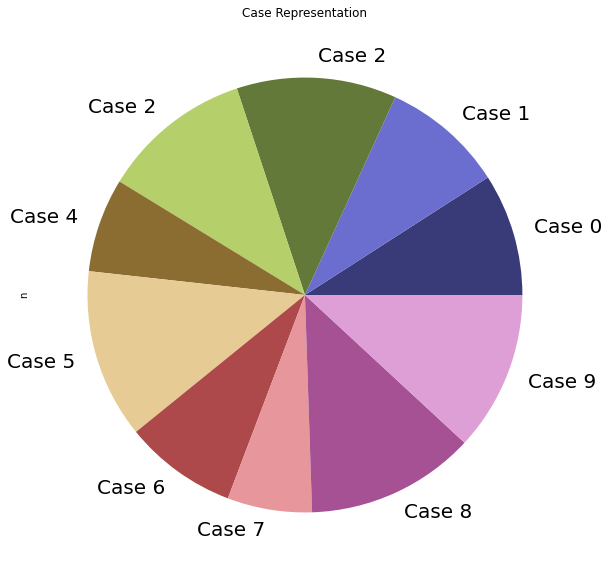

In [24]:
# Visualize representation
cases.n.plot.pie(
    figsize=[10,10], 
    title='Case Representation',
    labels=['Case 0', 'Case 1','Case 2','Case 2','Case 4','Case 5','Case 6','Case 7','Case 8','Case 9',],
    fontsize=20,
    cmap='tab20b'
    )

In [25]:
fig = px.pie(
    cases, 
    values='n', 
    names=['case 0', 'case 1', 'case 2', 'case 3', 'case 4', 'case 5', 'case 6', 'case 7', 'case 8', 'case 9'],
    title='Case Representation in Labeled Notes',
    )
fig.update_traces(
    textposition='inside', 
    textinfo='percent+label',
    #insidetextorientation='radial'
    )
fig.show()

---

### Make word lists by case from cleaned words



In [26]:
#Make word lists by case_num_xs from cleaned words
case0_words = ' '.join(df[df.case_num == 0].clean).split()
case1_words = ' '.join(df[df.case_num == 1].clean).split()
case2_words = ' '.join(df[df.case_num == 2].clean).split()
case3_words = ' '.join(df[df.case_num == 3].clean).split()
case4_words = ' '.join(df[df.case_num == 4].clean).split()
case5_words = ' '.join(df[df.case_num == 5].clean).split()
case6_words = ' '.join(df[df.case_num == 6].clean).split()
case7_words = ' '.join(df[df.case_num == 7].clean).split()
case8_words = ' '.join(df[df.case_num == 8].clean).split()
case9_words = ' '.join(df[df.case_num == 9].clean).split()
all_words = ' '.join(df.clean).split()


In [27]:
# Look at word list lengths
print('Case0 words: '+str(len(case0_words)))
print('Case1 words: '+str(len(case1_words)))
print('Case2 words: '+str(len(case2_words)))
print('Case3 words: '+str(len(case3_words)))
print('Case4 words: '+str(len(case4_words)))
print('Case5 words: '+str(len(case5_words)))
print('Case6 words: '+str(len(case6_words)))
print('Case7 words: '+str(len(case7_words)))
print('Case8 words: '+str(len(case8_words)))
print('Case9 words: '+str(len(case9_words)))
print('All words: '+str(len(all_words)))

Case0 words: 126022
Case1 words: 129025
Case2 words: 175950
Case3 words: 154512
Case4 words: 93390
Case5 words: 176058
Case6 words: 116700
Case7 words: 93204
Case8 words: 183600
Case9 words: 149379
All words: 1397840


In [28]:
# Calculate word frequencies
case0_freq = pd.Series(case0_words).value_counts()
case1_freq = pd.Series(case1_words).value_counts()
case2_freq = pd.Series(case2_words).value_counts()
case3_freq = pd.Series(case3_words).value_counts()
case4_freq = pd.Series(case4_words).value_counts()
case5_freq = pd.Series(case5_words).value_counts()
case6_freq = pd.Series(case6_words).value_counts()
case7_freq = pd.Series(case7_words).value_counts()
case8_freq = pd.Series(case8_words).value_counts()
case9_freq = pd.Series(case9_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

In [29]:
# Look at 20 most common words
word_counts = (pd.concat([all_freq, case0_freq, case1_freq, case2_freq, case3_freq, case4_freq, case5_freq, case6_freq, case7_freq, case8_freq, case9_freq], axis = 1, sort = True)
                .set_axis(['all', 'Case0', 'Case1', 'Case2', 'Case3', 'Case4', 'Case5', 'Case6', 'Case7', 'Case8', 'Case9'], axis = 1, inplace = False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))
word_counts.sort_values(by = 'all', ascending = False).head(20)

all  Case0  Case1  Case2  Case3  Case4  Case5  Case6  Case7  Case8  \
no       44474   3419   4628   5780   5904   2660   6264   2820   3384   5076   
pain     24728    832   4992   1479   7312    540   1044   4380    801    594   
none     17816   1729   2132   1224   1936   1340   3672   1008   1773    792   
denies   17746   1807   1508   2193   1600   1570   2088   1584   1089   2250   
ago      16876   1248   2665   2720    848    630   4122    780   1287   1998   
2        12877    728   1495   2346   2624    430   2124    216   1449    360   
last     11483   1833   1898   2652    528    290   1512    732   1206    594   
pmh      10607   1001    949   1241   1184    790   1242    888    756   1332   
-         9681    585    663   1054   1328    570   1116   1044    612   1332   
weeks     9316     39    949    476    704   1130   3186      0    279   2196   
3         9240    364    247   2499    208    200   1980    204    378   2412   
changes   9234   1170    351   1615    624    930   1224    420    702   1314   
months    9167   1430   1417   1411   1456     60    810    216   2331     36   
days      8786    702   1482   2703     16    130    540   1068   1017    720   
use       8782   1027    923    816    992    640   1188   1020    702    522   
ros       8328    754    689    850   1056    650   1026    816    513    954   
meds      7485    702    754    901    832    450    918    600    540    972   
past      7335    559   1209    833    576    390   1008    420    945    936   
patient   7103    533    689    799   1072    410   1170    612    396    504   
active    7026    754    858   1037    688    370    864    684    594    378   

         Case9  
no        4539  
pain      2754  
none      2210  
denies    2057  
ago        578  
2         1105  
last       238  
pmh       1224  
-         1377  
weeks      357  
3          748  
changes    884  
months       0  
days       408  
use        952  
ros       1020  
meds       816  
past       459  
patient    918  
active     799

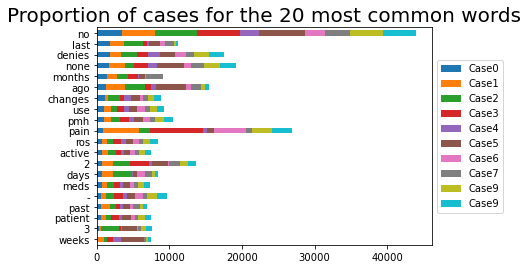

In [30]:
# figure out the percentage of language in words
(word_counts
 .assign(p_case0 = word_counts.Case0 / word_counts['all'],
        p_case1 = word_counts.Case1 / word_counts['all'],
        p_case2 = word_counts.Case2 / word_counts['all'],
        p_case3 = word_counts.Case3 / word_counts['all'],
        p_case4 = word_counts.Case4 / word_counts['all'],
        p_case5 = word_counts.Case5 / word_counts['all'],
        p_case6 = word_counts.Case6 / word_counts['all'],
        p_case7 = word_counts.Case7 / word_counts['all'],
        p_case8 = word_counts.Case8 / word_counts['all'],
        p_case9 = word_counts.Case9 / word_counts['all'])
        
 .sort_values(by = 'all')
 [['Case0', 'Case1', 'Case2', 'Case3', 'Case4', 'Case5', 'Case6', 'Case7', 'Case9', 'Case9']]
 .tail(20)
 .sort_values('Case0')
 .plot.barh(stacked=True))

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Proportion of cases for the 20 most common words', fontsize=20);

---

### Notes to self on publication quality figures

- PowerPoint specifies some default slide dimensions. 
- For a wide-screen presentation, they are `13.33in x 7.5in`. 
- Let's assume we will use a Full-HD projector, which has a width of 1920px and a height of 1080px.
  -  It gives a dpi of 144. 
  -  However, PowerPoint works with a default resolution of 96dpi.

```
import matplotlib 
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 

fig = plt.figure(figsize=(13.33,7.5), dpi=96)
plt.plot(x, y, linewidth=2)
plt.xlabel('X label (s)', fontsize=18)
plt.ylabel('Y label (V)', fontsize=18)
```

We have selected font sizes of **16** and **18**. These are reasonable values, but you may prefer to make them larger if you are presenting to large auditoriums. In most presentations, however, we won't show figures at full-screen. If we use two images side-by-side, we can have something like this:

`fig = plt.figure(figsize=(5,3), dpi=96)`

If we don't scale the image after we embed it into PowerPoint, we will have consistent figures. Perhaps they are full-screen, maybe they are displayed side-by-side, but all the axes and line thicknesses will be precisely the same.

---

### Look at bigrams by case

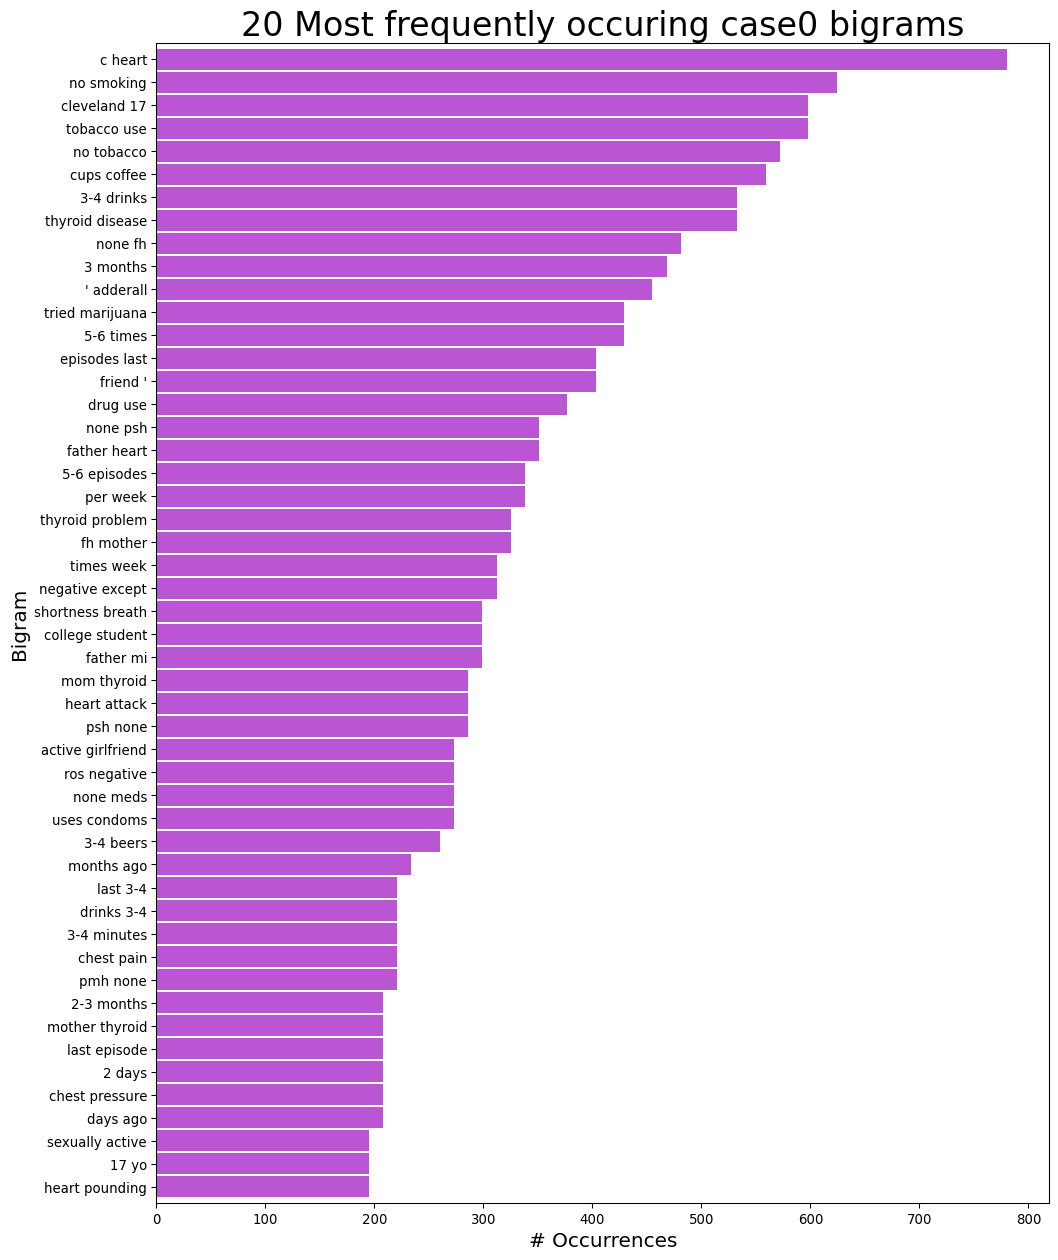

In [61]:
# Calculate Case 0bigrams
case0_bigrams = (pd.Series(nltk.ngrams(case0_words, 2))
                      .value_counts()
                      .head(50))
# Vizualize top case0 Bigrams
fig = plt.figure(figsize=(13.33,7.5), dpi=96)
case0_bigrams.sort_values().plot.barh(color = 'mediumorchid', width=.9, figsize=(12, 16))

plt.title('20 Most frequently occuring case0 bigrams', fontsize=25)
plt.ylabel('Bigram', fontsize=15)
plt.xlabel('# Occurrences', fontsize=15)

# make the labels pretty
ticks, _ = plt.yticks()
labels = case0_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

- **ros** review of systems?
- **pmh** past medical history

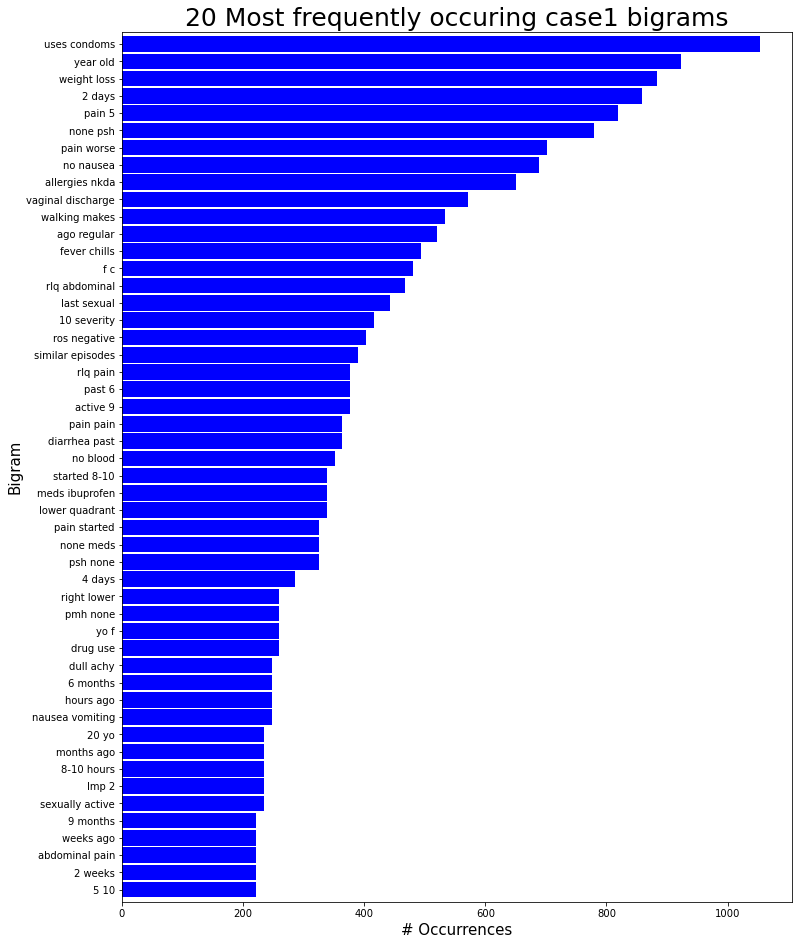

In [32]:
# Calculate Case 1 bigrams
case1_bigrams = (pd.Series(nltk.ngrams(case1_words, 2))
                      .value_counts()
                      .head(50))
# Vizualize top case1 Bigrams
case1_bigrams.sort_values().plot.barh(color = 'blue', width=.9, figsize=(12, 16))

plt.title('20 Most frequently occuring case1 bigrams', fontsize=25)
plt.ylabel('Bigram', fontsize=15)
plt.xlabel('# Occurrences', fontsize=15)

# make the labels pretty
ticks, _ = plt.yticks()
labels = case1_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

- [ ] **psh** ?
- [ ] **yo f** ? year-old female
- [ ] **rlq** right lower quadrant?
- [ ] **lmp**

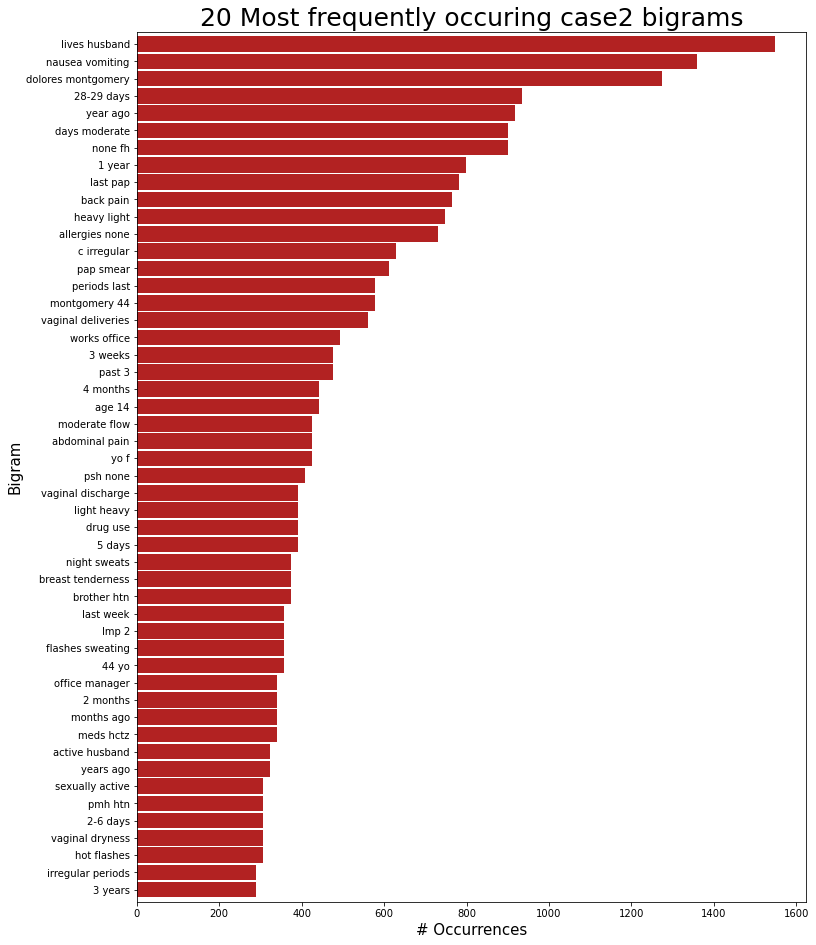

In [33]:
# Calculate Case 2 bigrams
case2_bigrams = (pd.Series(nltk.ngrams(case2_words, 2))
                      .value_counts()
                      .head(50))
# Vizualize top case2 Bigrams
case2_bigrams.sort_values().plot.barh(color = 'firebrick', width=.9, figsize=(12, 16))

plt.title('20 Most frequently occuring case2 bigrams', fontsize=25)
plt.ylabel('Bigram', fontsize=15)
plt.xlabel('# Occurrences', fontsize=15)

# make the labels pretty
ticks, _ = plt.yticks()
labels = case2_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

- **htn** hypertension
- **pmh** past medical history
- **hctz** Hydrochlorothiazide - diuretic, bp med
- **lmp** last menstrual period 

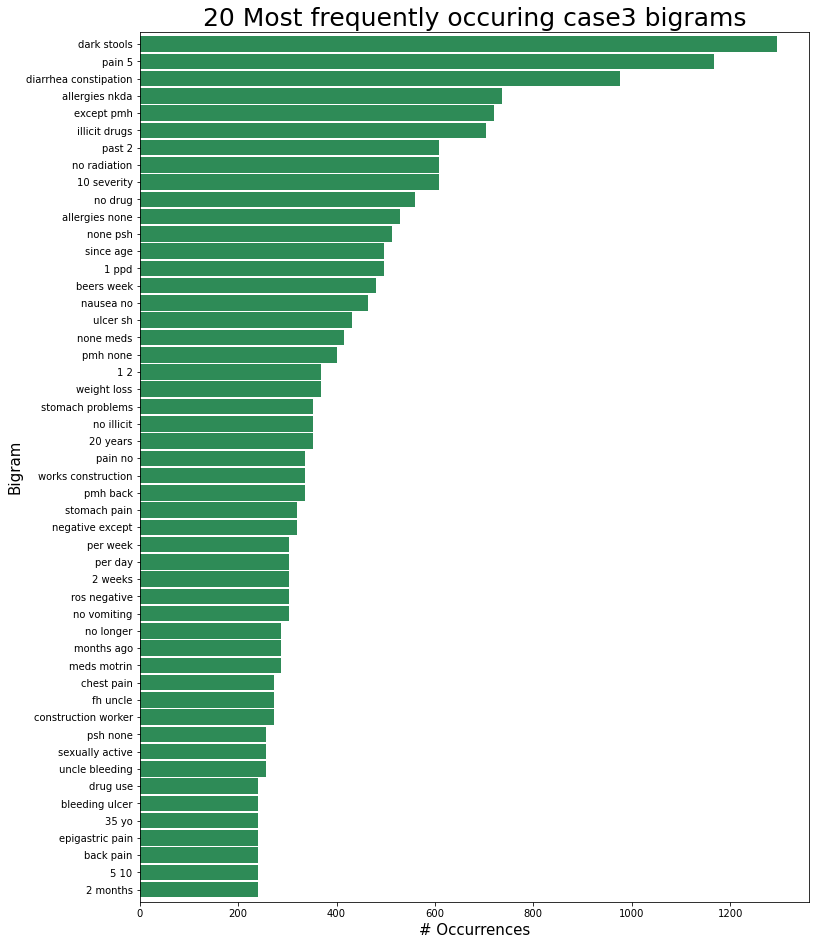

In [34]:
# Calculate Case 3 bigrams
case3_bigrams = (pd.Series(nltk.ngrams(case3_words, 2))
                      .value_counts()
                      .head(50))
# Vizualize top case3 Bigrams
case3_bigrams.sort_values().plot.barh(color = 'seagreen', width=.9, figsize=(12, 16))

plt.title('20 Most frequently occuring case3 bigrams', fontsize=25)
plt.ylabel('Bigram', fontsize=15)
plt.xlabel('# Occurrences', fontsize=15)

# make the labels pretty
ticks, _ = plt.yticks()
labels = case3_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

- **ros** review of systems
- **fh** family history
- [ ] **ppd**
- [ ] **psh**?

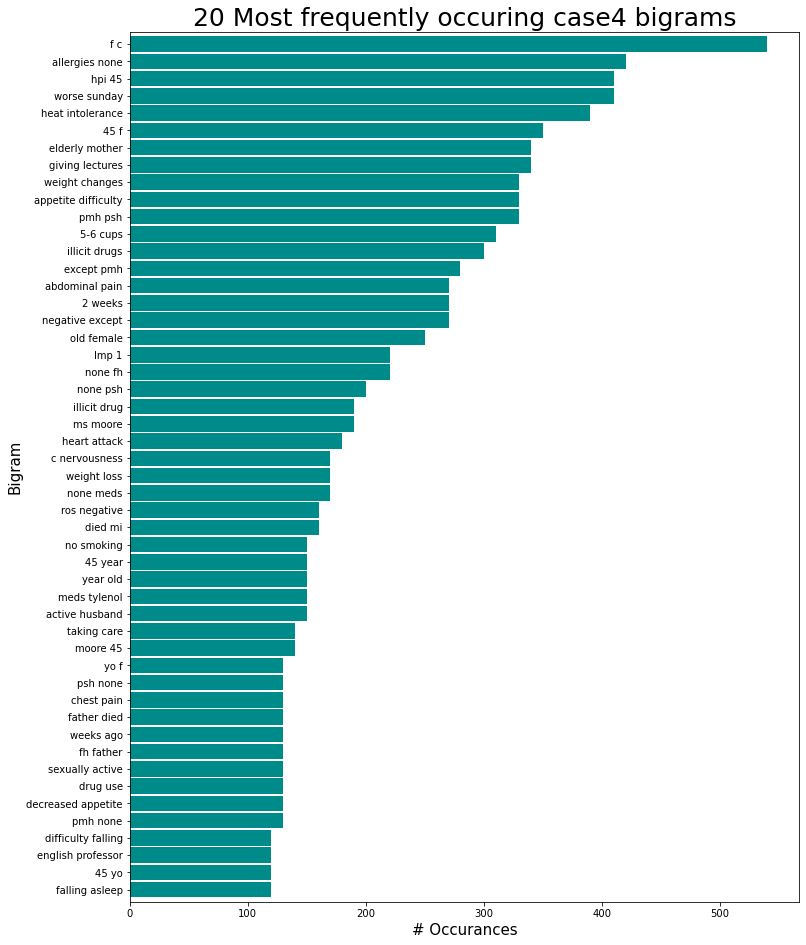

In [35]:
# Calculate Case 4 bigrams
case4_bigrams = (pd.Series(nltk.ngrams(case4_words, 2))
                      .value_counts()
                      .head(50))
# Vizualize top case4 Bigrams
case4_bigrams.sort_values().plot.barh(color = 'darkcyan', width=.9, figsize=(12, 16))

plt.title('20 Most frequently occuring case4 bigrams', fontsize=25)
plt.ylabel('Bigram', fontsize=15)
plt.xlabel('# Occurances', fontsize=15)

# make the labels pretty
ticks, _ = plt.yticks()
labels = case4_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

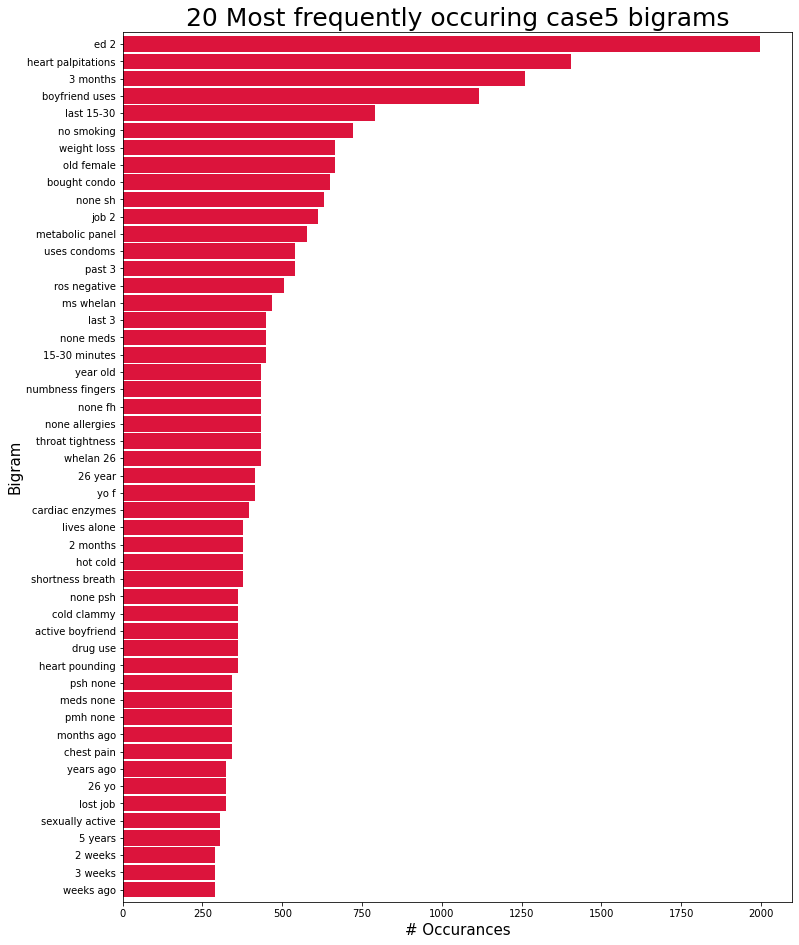

In [36]:
# Calculate Case 5bigrams
case5_bigrams = (pd.Series(nltk.ngrams(case5_words, 2))
                      .value_counts()
                      .head(50))
# Vizualize top case5 Bigrams
case5_bigrams.sort_values().plot.barh(color = 'crimson', width=.9, figsize=(12, 16))

plt.title('20 Most frequently occuring case5 bigrams', fontsize=25)
plt.ylabel('Bigram', fontsize=15)
plt.xlabel('# Occurances', fontsize=15)

# make the labels pretty
ticks, _ = plt.yticks()
labels = case5_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

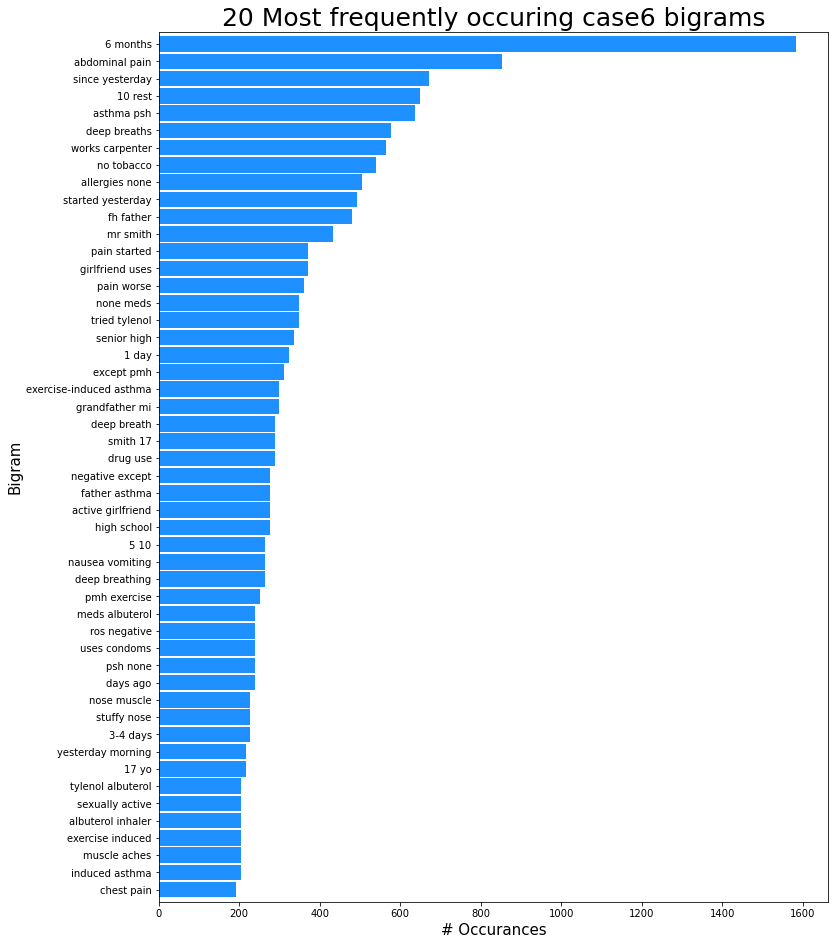

In [37]:
# Calculate Case 6 bigrams
case6_bigrams = (pd.Series(nltk.ngrams(case6_words, 2))
                      .value_counts()
                      .head(50))
# Vizualize top case6 Bigrams
case6_bigrams.sort_values().plot.barh(color = 'dodgerblue', width=.9, figsize=(12, 16))

plt.title('20 Most frequently occuring case6 bigrams', fontsize=25)
plt.ylabel('Bigram', fontsize=15)
plt.xlabel('# Occurances', fontsize=15)

# make the labels pretty
ticks, _ = plt.yticks()
labels = case6_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

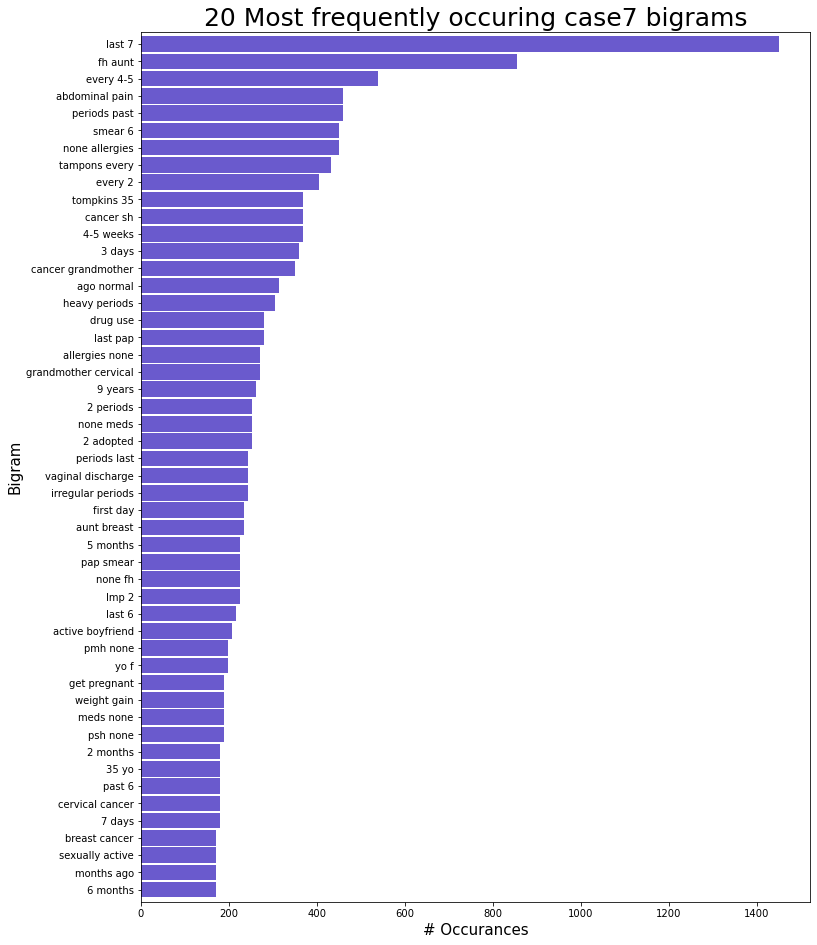

In [38]:
# Calculate Case 7 bigrams
case7_bigrams = (pd.Series(nltk.ngrams(case7_words, 2))
                      .value_counts()
                      .head(50))
# Vizualize top case7 Bigrams
case7_bigrams.sort_values().plot.barh(color = 'slateblue', width=.9, figsize=(12, 16))

plt.title('20 Most frequently occuring case7 bigrams', fontsize=25)
plt.ylabel('Bigram', fontsize=15)
plt.xlabel('# Occurances', fontsize=15)

# make the labels pretty
ticks, _ = plt.yticks()
labels = case7_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

- **lmp**

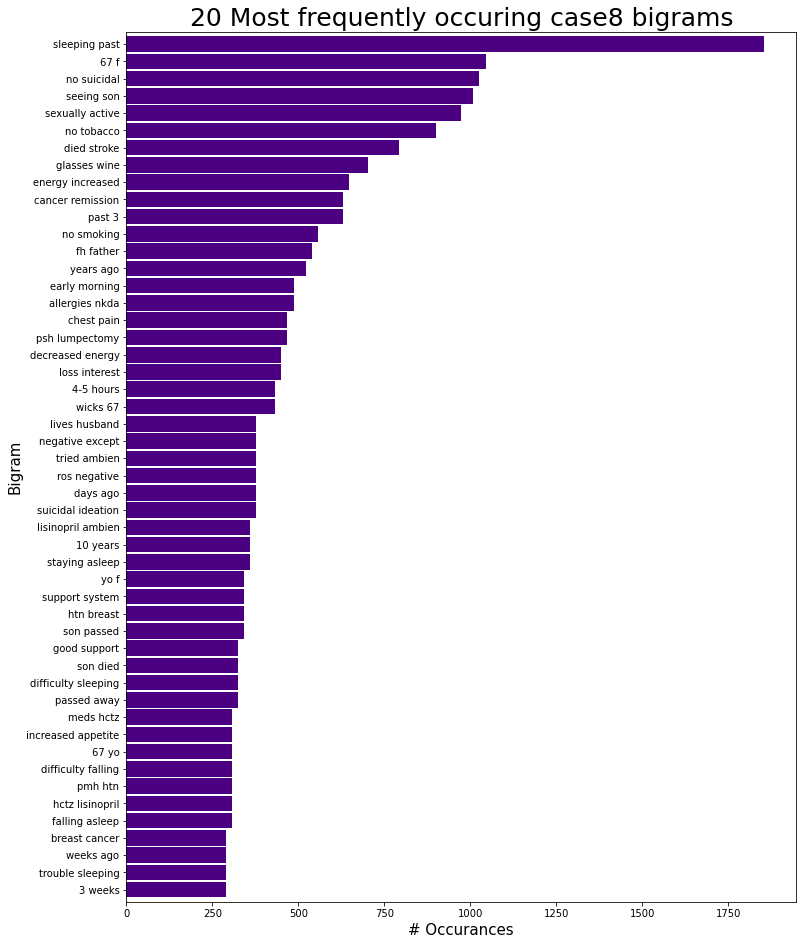

In [39]:
# Calculate Case 8 bigrams
case8_bigrams = (pd.Series(nltk.ngrams(case8_words, 2))
                      .value_counts()
                      .head(50))
# Vizualize top case8 Bigrams
case8_bigrams.sort_values().plot.barh(color = 'indigo', width=.9, figsize=(12, 16))

plt.title('20 Most frequently occuring case8 bigrams', fontsize=25)
plt.ylabel('Bigram', fontsize=15)
plt.xlabel('# Occurances', fontsize=15)

# make the labels pretty
ticks, _ = plt.yticks()
labels = case8_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

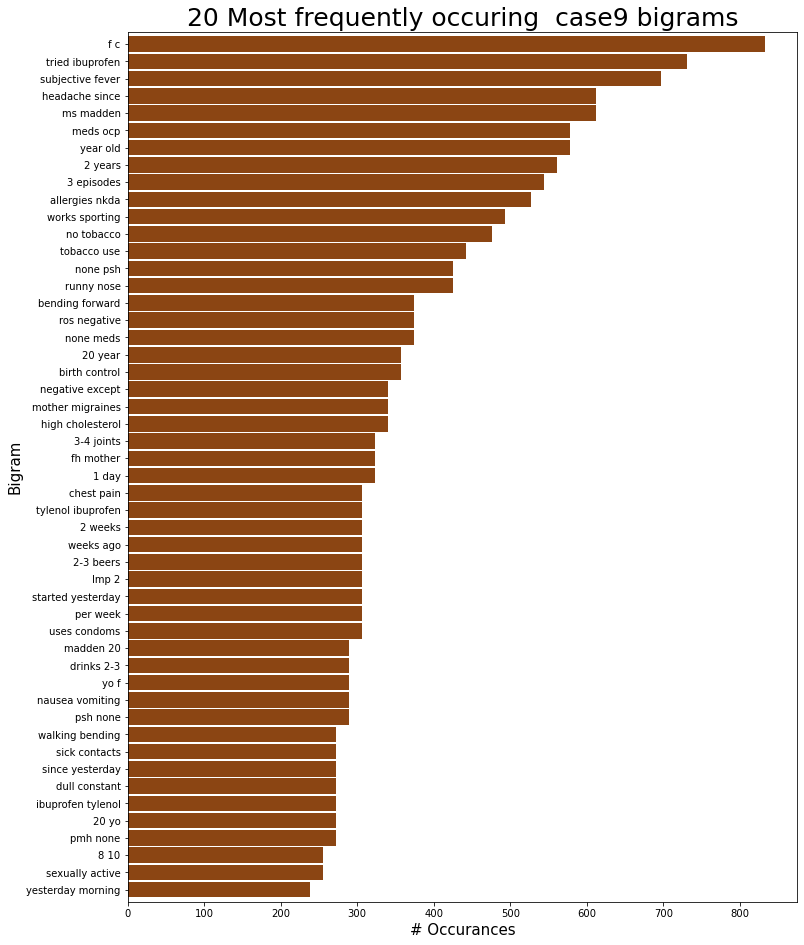

In [40]:
# Calculate Case 9 bigrams
case9_bigrams = (pd.Series(nltk.ngrams( case9_words, 2))
                      .value_counts()
                      .head(50))
# Vizualize top  case9 Bigrams
case9_bigrams.sort_values().plot.barh(color = 'saddlebrown', width=.9, figsize=(12, 16))

plt.title('20 Most frequently occuring  case9 bigrams', fontsize=25)
plt.ylabel('Bigram', fontsize=15)
plt.xlabel('# Occurances', fontsize=15)

# make the labels pretty
ticks, _ = plt.yticks()
labels =  case9_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

In [69]:
13.33*96


1279.68

In [70]:
7.5*96

720.0

---

### Word Clouds

In [66]:
# Create word clouds for all words and language families
all_cloud = WordCloud(background_color = 'white', height = 900 , width = 1600).generate(' '.join(all_words))
case0_cloud = WordCloud(background_color = 'white', height = 900, width = 1600).generate(' '.join(case0_words))
case1_cloud = WordCloud(background_color = 'white', height = 900, width = 1600).generate(' '.join(case1_words))
case2_cloud = WordCloud(background_color = 'white', height = 900, width = 1600).generate(' '.join(case2_words))
case3_cloud = WordCloud(background_color = 'white', height = 900, width = 1600).generate(' '.join(case3_words))
case4_cloud = WordCloud(background_color = 'white', height = 900, width = 1600).generate(' '.join(case4_words))
case5_cloud = WordCloud(background_color = 'white', height = 900, width = 1600).generate(' '.join(case5_words))
case6_cloud = WordCloud(background_color = 'white', height = 900, width = 1600).generate(' '.join(case6_words))
case7_cloud = WordCloud(background_color = 'white', height = 900, width = 1600).generate(' '.join(case7_words))
case8_cloud = WordCloud(background_color = 'white', height = 900, width = 1600).generate(' '.join(case8_words))
case9_cloud = WordCloud(background_color = 'white', height = 900, width = 1600).generate(' '.join(case9_words))



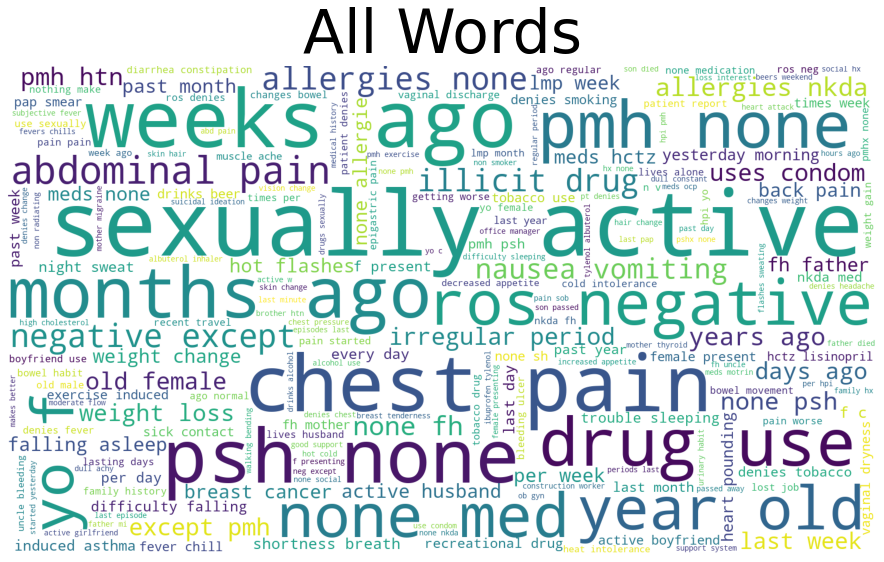

In [73]:
#fig = plt.figure(figsize=(13.33,7.5), dpi=96)
plt.figure(figsize = (16, 9))
plt.imshow(all_cloud);
plt.title('All Words', fontsize=60)
plt.axis('off');

(-0.5, 1599.5, 899.5, -0.5)

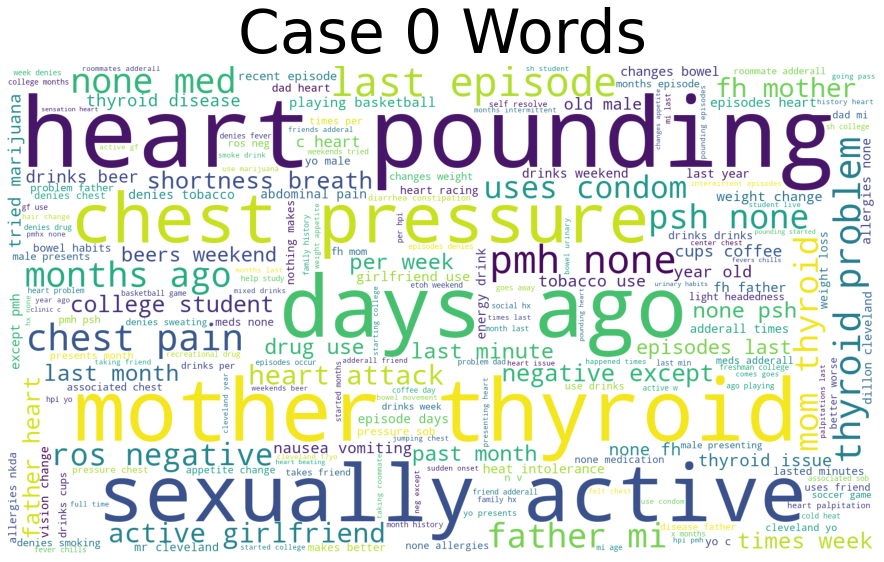

In [74]:
plt.figure(figsize = (16, 9))
plt.imshow(case0_cloud);
plt.title('Case 0 Words', fontsize=60)
plt.axis('off')


(-0.5, 1599.5, 899.5, -0.5)

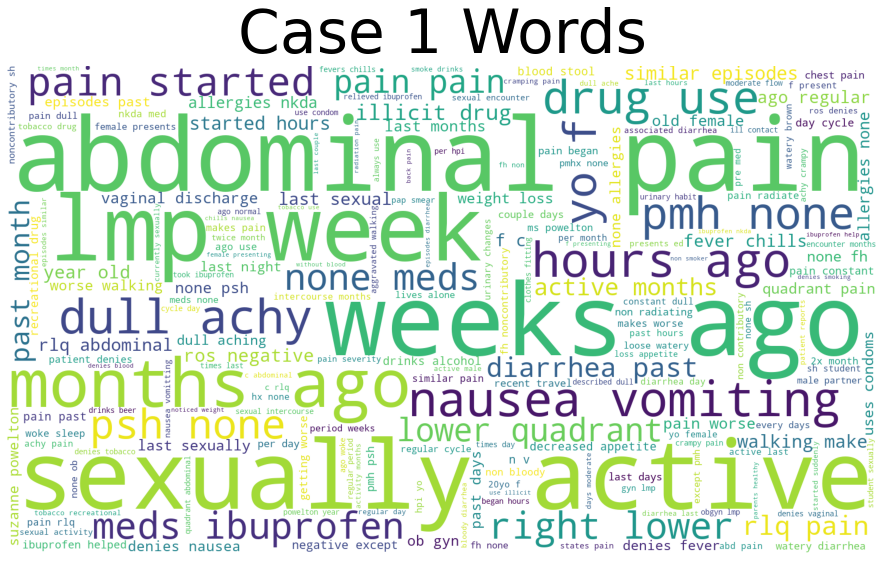

In [75]:
plt.figure(figsize = (16, 9))
plt.imshow(case1_cloud);
plt.title('Case 1 Words', fontsize=60)
plt.axis('off')


(-0.5, 1599.5, 899.5, -0.5)

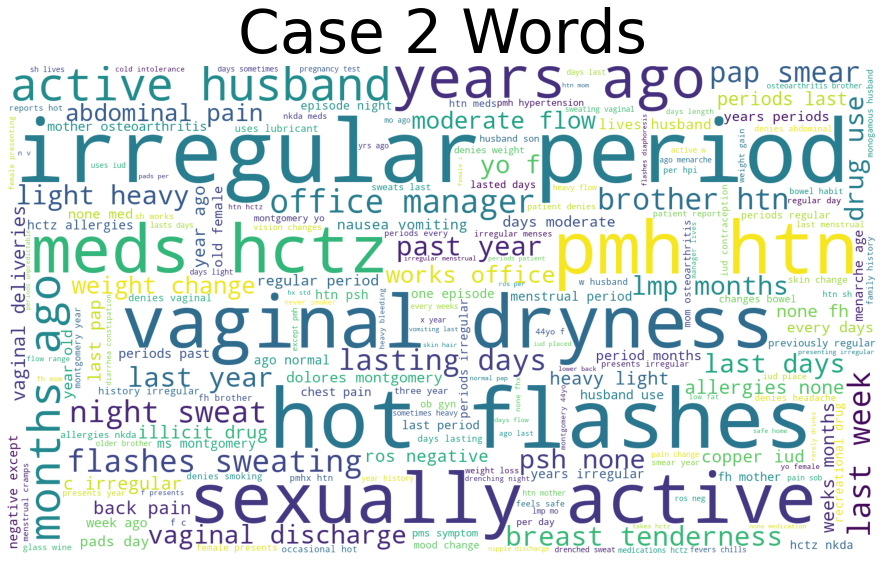

In [76]:
plt.figure(figsize = (16, 9))
plt.imshow(case2_cloud);
plt.title('Case 2 Words', fontsize=60)
plt.axis('off')


(-0.5, 1599.5, 899.5, -0.5)

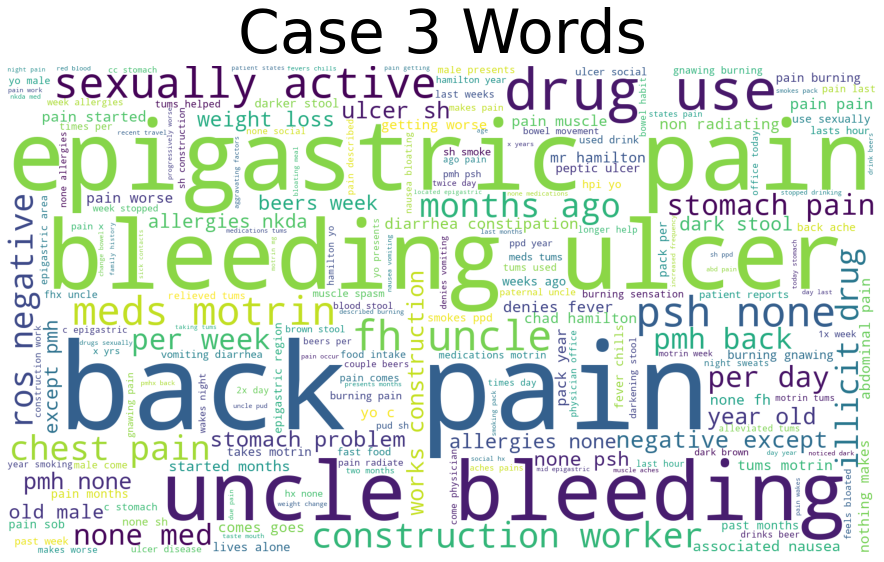

In [77]:
plt.figure(figsize = (16, 9))
plt.imshow(case3_cloud);
plt.title('Case 3 Words', fontsize=60)
plt.axis('off')


(-0.5, 1599.5, 899.5, -0.5)

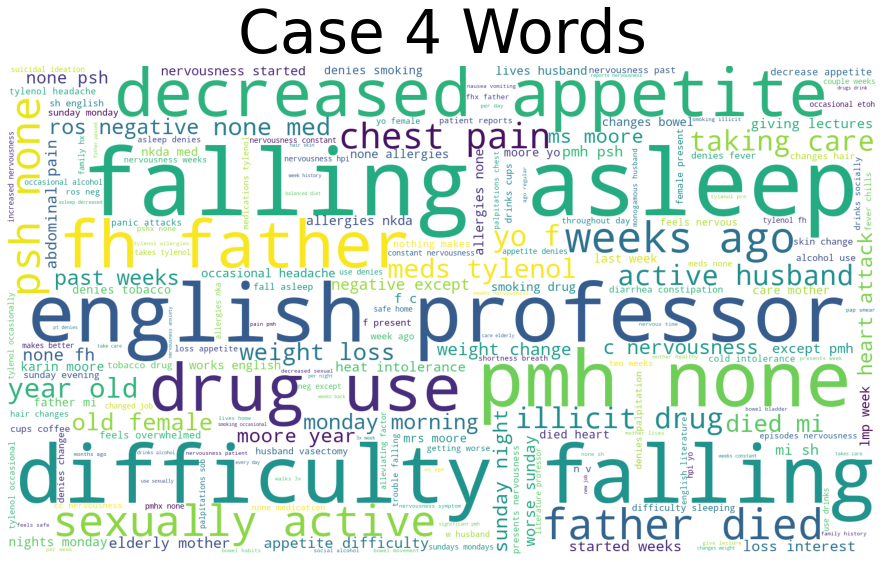

In [78]:
plt.figure(figsize = (16, 9))
plt.imshow(case4_cloud);
plt.title('Case 4 Words', fontsize=60)
plt.axis('off')


(-0.5, 1599.5, 899.5, -0.5)

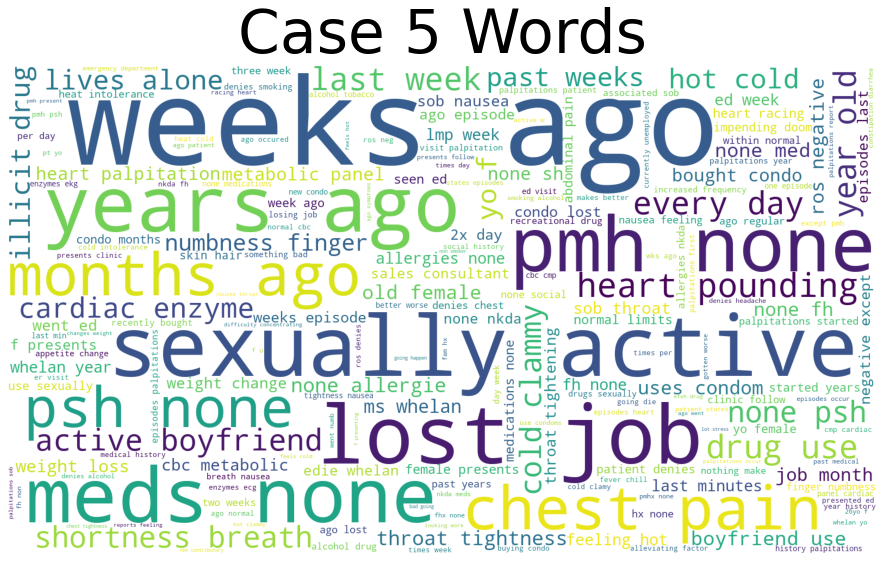

In [79]:
plt.figure(figsize = (16, 9))
plt.imshow(case5_cloud);
plt.title('Case 5 Words', fontsize=60)
plt.axis('off')


(-0.5, 1599.5, 899.5, -0.5)

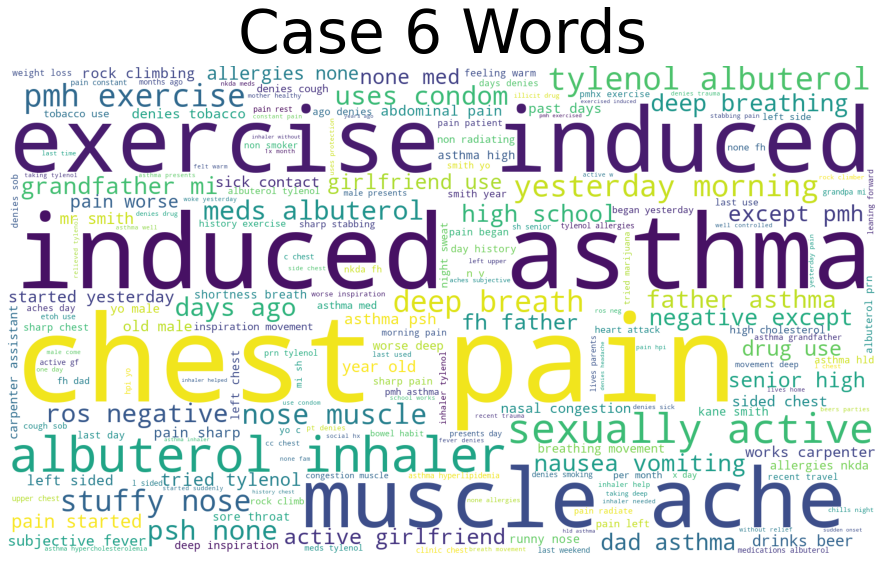

In [80]:
plt.figure(figsize = (16, 9))
plt.imshow(case6_cloud);
plt.title('Case 6 Words', fontsize=60)
plt.axis('off')


(-0.5, 1599.5, 899.5, -0.5)

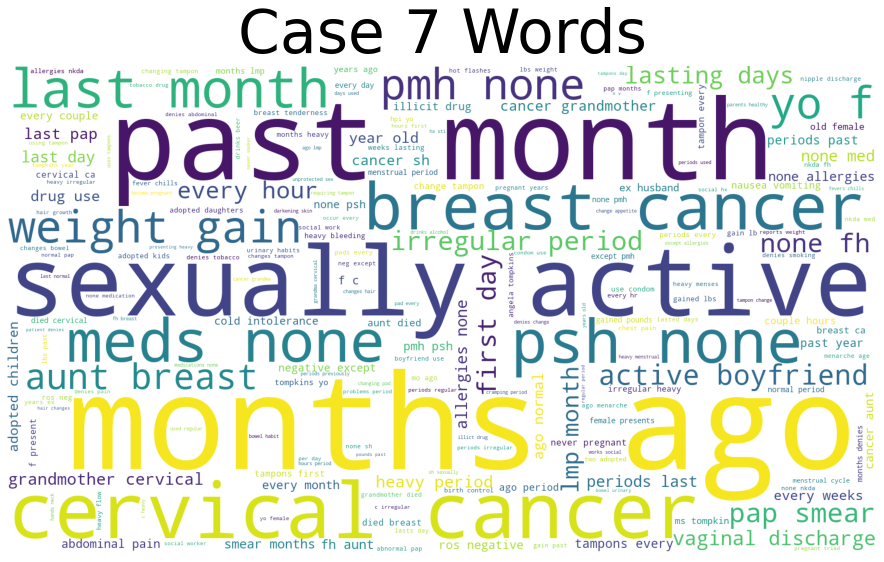

In [82]:
plt.figure(figsize = (16, 9))
plt.imshow(case7_cloud);
plt.title('Case 7 Words', fontsize=60)
plt.axis('off')


(-0.5, 1599.5, 899.5, -0.5)

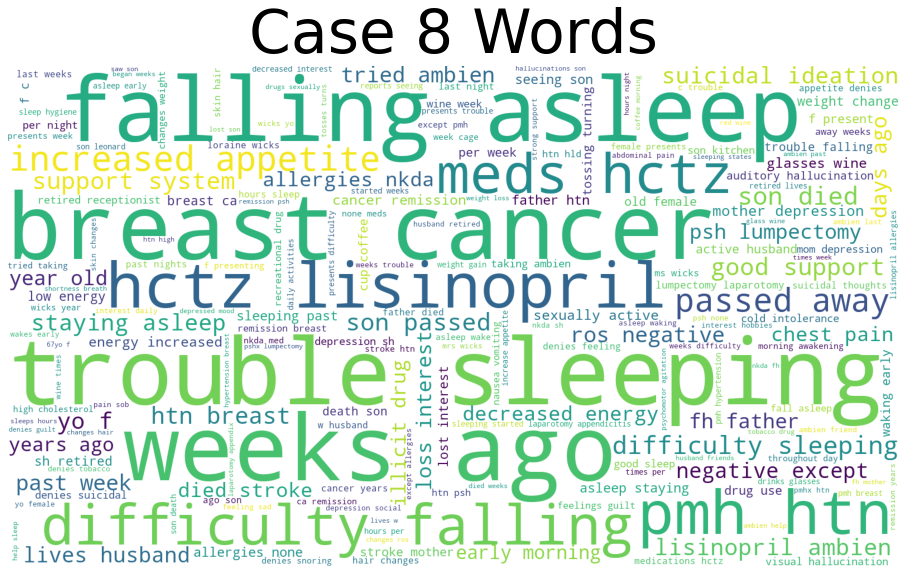

In [83]:
plt.figure(figsize = (16, 19))
plt.imshow(case8_cloud);
plt.title('Case 8 Words', fontsize=60)
plt.axis('off')


(-0.5, 1599.5, 899.5, -0.5)

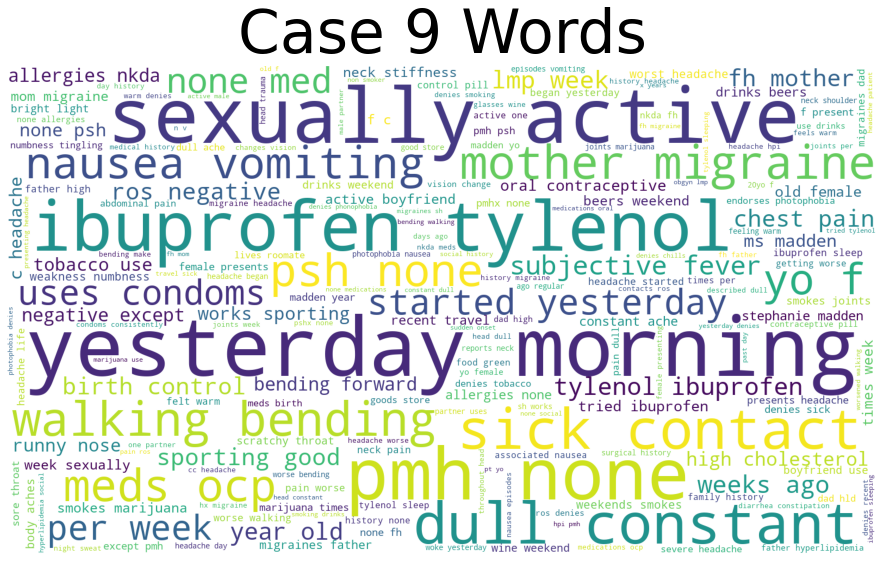

In [84]:
plt.figure(figsize = (16, 9))
plt.imshow(case9_cloud);
plt.title('Case 9 Words', fontsize=60)
plt.axis('off')


---

## Takeaways

[ ] Record some observations

## Modeling

- For our first model, we will use the words from the patient note to predict what case is represented.
- The cases are very different. This would be a trivial task for a human
- We anticipate the model will perform well given how different the case notes are

### Split data

- We will split into train and test
- Use k-fold cross-validation for model tuning instead of creating separate, out-of-sample-validate split

### X/y split

- **X:** Use TF-IDF vectorization of lemmatized notes
- **Y:** Use case number

In [53]:
# Split X Y
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df.lemmatized)
y = df.case_num

In [54]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2, random_state=123)

### Baseline

In [55]:
# look for mode
df.case_num.value_counts()

5    1800
8    1800
2    1700
9    1700
3    1600
0    1300
1    1300
6    1200
4    1000
7     900
Name: case_num, dtype: int64

Bimodal - cases 5 and 8. Set baseline to case5

In [56]:
# baseline
df[df['case_num'] == 5].case_num.value_counts()/sum(df.case_num.value_counts())

5    0.125874
Name: case_num, dtype: float64

Baseline is 12.58%

In [57]:
import warnings
warnings.filterwarnings("ignore")


In [58]:
# Calculate baseline model performance
print('BASELINE PERFORMANCE')
print('---')
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.baseline)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.actual, train.baseline))
print('---')
print(classification_report(train.actual, train.baseline))


BASELINE PERFORMANCE
---


NameError: name 'train' is not defined

---

## Create Models

### Logistic Regression

In [ ]:
# Make and fit the object
lm = LogisticRegression().fit(X_train, y_train)
# Use it to make predictions
train['lm_predicted'] = lm.predict(X_train)
# Asssess accuracy
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.lm_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.lm_predicted, train.actual))
print('---')
print(classification_report(train.actual, train.lm_predicted))
print('---')
print('5-Fold Cross Validation')
print(cross_val_score(lm, X_train, y_train, cv = 5))


### Random Forest

In [ ]:
# Make and fit object
rf = RandomForestClassifier(bootstrap = True, 
                            class_weight = None, 
                            criterion = 'gini',
                            min_samples_leaf = 3,
                            n_estimators = 100,
                            max_depth = 8, 
                            random_state = 123).fit(X_train, y_train)
# Use it to make predictions
train['rf_predicted'] = rf.predict(X_train)
# Assess performance
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.rf_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.rf_predicted, train.actual))
print('---')
print(classification_report(train.actual, train.rf_predicted))
print('---')
print('5-Fold Cross Validation')
print(cross_val_score(rf, X_train, y_train, cv = 5))

### KNN

In [ ]:
# Make and fit the object
knn = KNeighborsClassifier(n_neighbors = 4).fit(X_train, y_train)
# Use the object 
train['knn_predicted'] = knn.predict(X_train)
# Evaluate performance
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.knn_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.knn_predicted, train.actual))
print('---')
print(classification_report(train.actual, train.knn_predicted))
print('---')
print('5-Fold Cross Validation')
print(cross_val_score(knn, X_train, y_train, cv = 5))

### Support Vector Classifier

In [ ]:
# Make and fit the object
svc = LinearSVC(random_state=0).fit(X_train, y_train)
# Use the object
train['svc_predicted'] = svc.predict(X_train)
# Evaluate model
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.svc_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.svc_predicted, train.actual))
print('---')
print(classification_report(train.actual, train.svc_predicted))
print('---')
print('5-Fold Cross Validation')
print(cross_val_score(svc, X_train, y_train, cv = 5))


---

## Test

### Test KNN model on out-of-sample Data

In [ ]:
# Create testing dataframe
test = pd.DataFrame(dict(actual=y_test))
test['knn_predicted'] = knn.predict(X_test)
# Evaluate model
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.knn_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.knn_predicted, test.actual))
print('---')
print(classification_report(test.actual, test.knn_predicted))

In [ ]:
# Calculate percent improvement from baseline accuracy (47%)
pct_improvement = round(((100-12.56)/(12.56)*100), 2)
print(f'Our 100% accuracy represent a {pct_improvement}% improvement from baseline')

### Takeaways

- As we predicted, the model was able to accurately predict the case number from clinical notes
- This is a trivial task for a human
- The value of this model is the throughput
- There are almost four million words in our corpus
- The average reading speed is 200-250 words per minute
- At 225 WPM, it would take a person over 12 days and 8 hours to read all of the patient notes.
- This algorithm can assign cases much faster

---

## Now what?

We are really interested in modeling the features present in notes, not the case numbers

### Case for LSTM model / Word Embedding

- "Denies shortness of breath, diaphoresis, fevers, chills, headache, fatigue, changes in sleep, changes in vision/hearing, abdominal paun, changes in bowel or urinary habits."
- Word negating list of conditions distant.
- TF-IDF won't work